# Occupancy Detection from IoT Sensors

## Data Cleansing

In [197]:
import pandas as pd

In [ ]:
df = pd.read_csv("../data/raw/Occupancy.csv")
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
1,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
2,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
3,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
4,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [199]:
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,0.231031
std,1.055315,4.982154,210.430875,311.201281,0.000768,0.421503
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,21.525000,31.290000,301.000000,804.666667,0.004832,0.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


Columns that contain a single value

In [200]:
df.columns[df.nunique() <= 1]

Index([], dtype='object')

Columns that contain a few values

In [201]:
df.columns[df.nunique() <= 50]

Index(['Occupancy'], dtype='object')

Columns with low variance

In [202]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
numeric_columns = df.select_dtypes(include=["number"])

selector.fit(numeric_columns)
support_mask = selector.get_support()

low_variance_columns = numeric_columns.columns[~support_mask]
print(f"Low variance columns: {low_variance_columns.tolist()}")

Low variance columns: ['HumidityRatio']


Identify and remove rows with duplicate data

In [203]:
len(df.drop_duplicates()) == len(df)

True

Identify and remove missing values

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20560 entries, 0 to 20559
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20560 non-null  object 
 1   Temperature    20560 non-null  float64
 2   Humidity       20560 non-null  float64
 3   Light          20560 non-null  float64
 4   CO2            20560 non-null  float64
 5   HumidityRatio  20560 non-null  float64
 6   Occupancy      20560 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.1+ MB


Data distributions

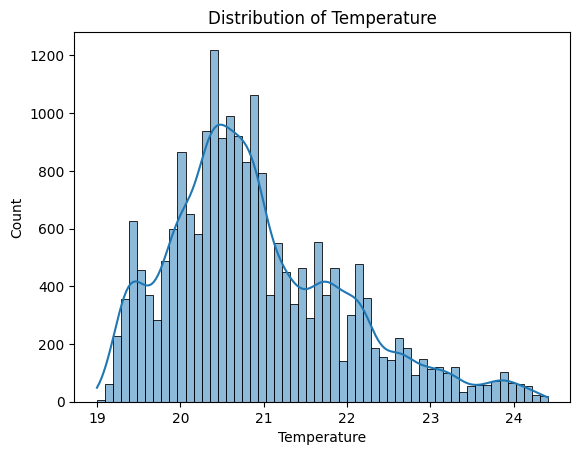

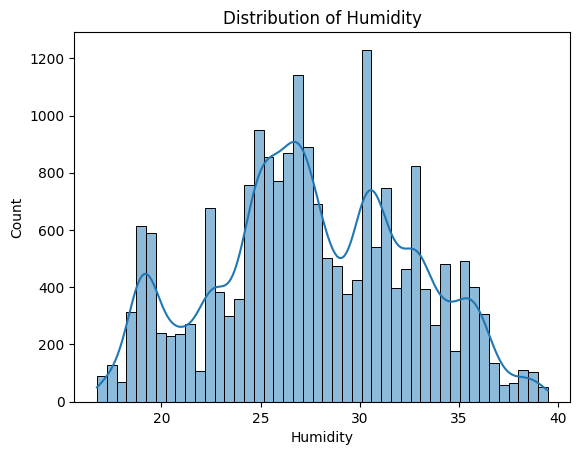

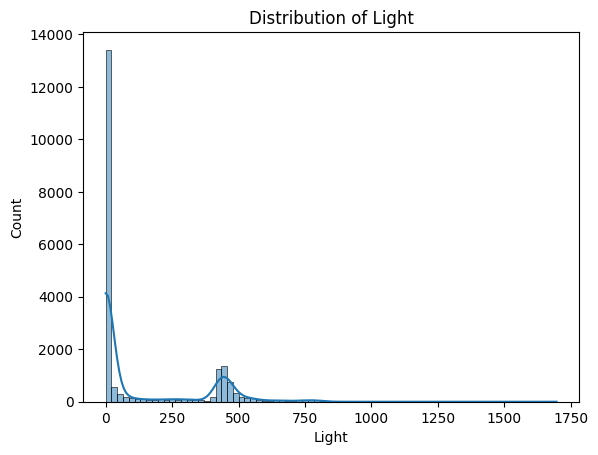

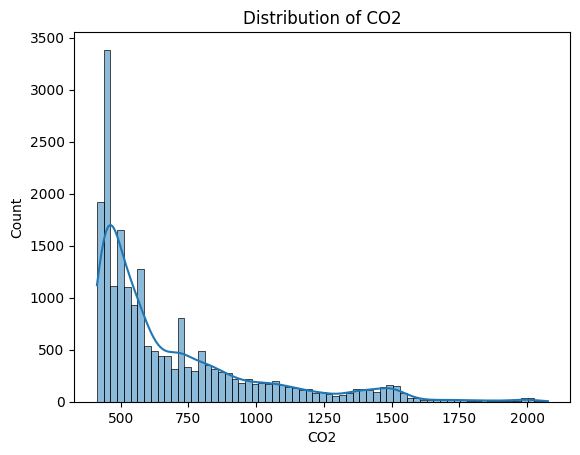

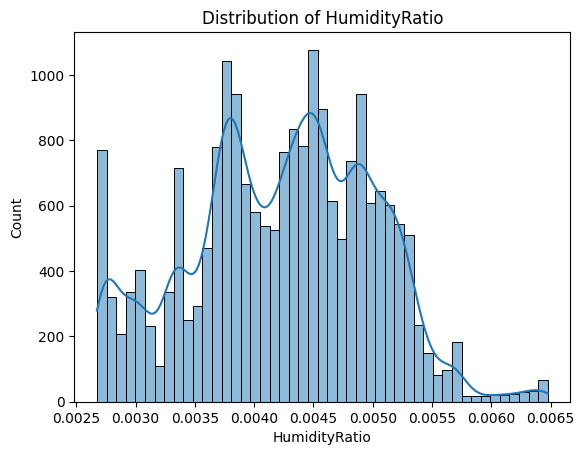

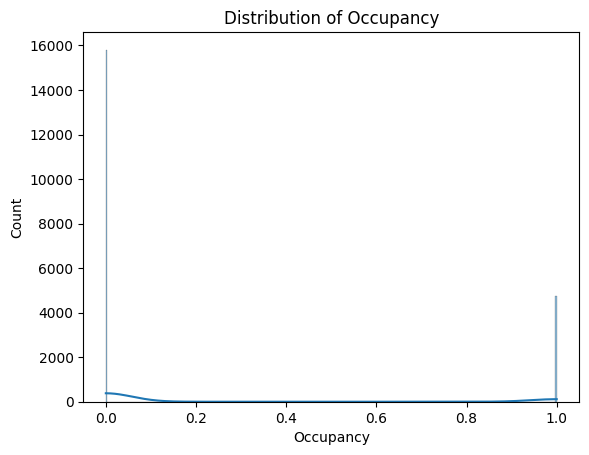

In [205]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in df.select_dtypes(include="number").columns:
    plt.figure()
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

In [206]:
from scipy.stats import normaltest

for col in df.select_dtypes(include="number").columns:
    stat, p = normaltest(df[col].dropna())
    print(f"{col}: p-value = {p:.4f} {'(Normal)' if p > 0.05 else '(Not normal)'}")

Temperature: p-value = 0.0000 (Not normal)
Humidity: p-value = 0.0000 (Not normal)
Light: p-value = 0.0000 (Not normal)
CO2: p-value = 0.0000 (Not normal)
HumidityRatio: p-value = 0.0000 (Not normal)
Occupancy: p-value = 0.0000 (Not normal)


Outlier detection

Due to non-normality of the data, I will avoid Z-score methods for outlier detection and use the IQR method.

In [207]:
numeric_df = df.select_dtypes(include="number").drop(columns=["Occupancy"])

Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = (numeric_df < lower_bound) | (numeric_df > upper_bound)

outliers_count = outliers.sum()
outliers_percentage = (outliers_count / len(df)) * 100

outliers_summary = pd.DataFrame({
    "Outlier Count": outliers_count,
    "Outlier Percentage (%)": outliers_percentage.round(2)
})

print(outliers_summary)

               Outlier Count  Outlier Percentage (%)
Temperature              519                    2.52
Humidity                   0                    0.00
Light                    183                    0.89
CO2                     1449                    7.05
HumidityRatio              0                    0.00


In [208]:
df = df[~outliers.any(axis=1)].reset_index(drop=True)
print(f"Data shape after outlier removal: {df.shape}")

Data shape after outlier removal: (18538, 7)


## Feature Selection

Quick feature explanation:

1) Temperature: Room temperature — influences comfort, may affect occupancy.

2) Humidity: Air moisture level — affects environment conditions.

3) Light: Light intensity — can indicate presence or activity in the room.

4) CO2: Carbon dioxide concentration — higher levels often correlate with occupancy.

5) HumidityRatio: Ratio related to humidity and temperature — another measure of moisture.

6) Occupancy: Target variable (binary) — 1 if the room is occupied, 0 otherwise.

In [209]:
df["Occupancy"].value_counts()

Occupancy
0    14781
1     3757
Name: count, dtype: int64

In [210]:
df = df.drop(["date"], axis=1)

ANOVA (Analysis of Variance) for feature selection is a great choice when you have:

1) Numerical input features.

2) Categorical target (Occupancy).

ANOVA checks whether the means of numeric features differ significantly between classes (e.g., Occupied vs Not Occupied).

Higher F-score -> feature more strongly distinguishes between occupancy classes.

Lower p-value -> more statistically significant.

Typically, p < 0.05 means it's a useful feature.

In [211]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

X = df.drop(columns=["Occupancy"])
y = df["Occupancy"]

selector = SelectKBest(score_func=f_classif, k="all")
selector.fit(X, y)

f_scores = selector.scores_
p_values = selector.pvalues_

anova_results = pd.DataFrame({
    "Feature": X.columns,
    "F-Score": f_scores,
    "p-Value": p_values
}).sort_values(by="F-Score", ascending=False)

print(anova_results)

         Feature        F-Score        p-Value
2          Light  110419.587296   0.000000e+00
3            CO2   11655.528836   0.000000e+00
0    Temperature    8466.277456   0.000000e+00
4  HumidityRatio     509.939767  2.074901e-111
1       Humidity      15.641332   7.684733e-05


Kendall's Tau is also a useful method when dealing with numerical inputs and a categorical output.

Instead of using the actual numeric values of variables, Kendall's Tau compares the rankings (i.e., orderings).

In [212]:
from scipy.stats import kendalltau

kendall_results = []

for col in X.columns:
    tau, p = kendalltau(X[col], y)
    kendall_results.append((col, tau, p))

kendall_df = pd.DataFrame(kendall_results, columns=["Feature", "Kendall Tau", "p-Value"])
kendall_df = kendall_df.sort_values(by="Kendall Tau", key=abs, ascending=False)

print(kendall_df)

         Feature  Kendall Tau        p-Value
2          Light     0.740169   0.000000e+00
3            CO2     0.460814   0.000000e+00
0    Temperature     0.450104   0.000000e+00
4  HumidityRatio     0.131386  2.446417e-106
1       Humidity    -0.017835   2.985603e-03


Light is by far the strongest predictor. It has the highest ANOVA F-score and the strongest Kendall’s Tau correlation with occupancy, meaning it shows both a strong linear relationship and a strong monotonic association with whether a space is occupied or not. I should definitely keep it.

CO₂ and Temperature are also very informative. They both rank high in ANOVA and show strong positive correlations with occupancy in Kendall’s Tau. In practical terms, higher CO₂ levels and rising temperature often indicate the presence of people in a room — which makes sense. These features are worth keeping as well.

HumidityRatio shows some significance in ANOVA and a weak but still positive correlation in Kendall’s Tau. It’s not as strong as the top three, but it might add marginal value. I can keep it and see if it improves the model or drop it for simplicity.

Humidity, on the other hand, is weak across the board. It has a low F-score, a negligible negative Kendall correlation, and isn’t likely to contribute much to prediction accuracy. It’s a good candidate for removal.

In [213]:
df = df.drop(columns=["Humidity"])

# Data Transforms

Splitting the data

In [214]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Occupancy"])
y = df["Occupancy"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state=42,
    stratify=y
)

Scaling the data

In [215]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Save the data

In [ ]:
import joblib

joblib.dump(X_train_scaled, "../data/processed/X_train_scaled.joblib")
joblib.dump(X_test_scaled, "../data/processed/X_test_scaled.joblib")
joblib.dump(y_train, "../data/processed/y_train.joblib")
joblib.dump(y_test, "../data/processed/y_test.joblib")

['y_test.joblib']